# Red neuronal para predecir poses

## Importar librerias

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt

import tensorflow as tf
from keras import layers,callbacks
from keras.models import Sequential, load_model
from keras.optimizers import Adam

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

tf.config.list_physical_devices('GPU')
print(tf.test.is_built_with_cuda(), tf.test.is_gpu_available())

2025-07-23 16:30:06.513218: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-23 16:30:06.522615: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753309806.533513  324962 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753309806.536777  324962 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753309806.544620  324962 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True False


2025-07-23 16:30:08.483541: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2025-07-23 16:30:08.483566: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:178] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-07-23 16:30:08.483569: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:183] retrieving CUDA diagnostic information for host: misael-ROG-Strix-G16
2025-07-23 16:30:08.483571: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:190] hostname: misael-ROG-Strix-G16
2025-07-23 16:30:08.483656: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:197] libcuda reported version is: 550.163.1
2025-07-23 16:30:08.483665: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:201] kernel reported v

## Preparar datos

In [2]:
DATA      = Path("../data").resolve()
TRAIN_VAL = DATA / "train_val_csv"
TEST      = DATA / "test_csv"
Salida    = Path("dataset_completo.csv")
#
# Unir los csvs de entrenamiento para hacer uno solo
def une_csvs(carpeta):
    csvs = [p for p in DATA.rglob("*.csv") if p.parent==carpeta and p.stem!=Salida.stem]
    df =pd.concat((pd.read_csv(f) for f in csvs),ignore_index=True)
    df = df.drop_duplicates().reset_index(drop=True)
    df.to_csv(carpeta/Salida, index=False, float_format="%.6f")

    x= df.drop(columns=['label'])
    y= df['label']
    y_one_hot =poses_lb.fit_transform(y)
    return df,x,y,y_one_hot
#
poses_lb   =LabelBinarizer()
#
df_train_val,X_train_val,Y_train_val,Y_oh_train_val=une_csvs(TRAIN_VAL)
#
df_test, X_test, Y_test, Y_oh_test=une_csvs(TEST)

print(Y_oh_train_val,Y_train_val)

print(Y_oh_test,Y_test)

[[0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 ...
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]] 0                 OTRO
1                 OTRO
2                 OTRO
3                 OTRO
4                 OTRO
             ...      
2080    POSICION_FETAL
2081    POSICION_FETAL
2082    POSICION_FETAL
2083    POSICION_FETAL
2084    POSICION_FETAL
Name: label, Length: 2085, dtype: object
[[0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 ...
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]] 0                 OTRO
1                 OTRO
2                 OTRO
3                 OTRO
4                 OTRO
             ...      
1461    POSICION_FETAL
1462    POSICION_FETAL
1463    POSICION_FETAL
1464    POSICION_FETAL
1465    POSICION_FETAL
Name: label, Length: 1466, dtype: object


## Preparar datos (Test)

## Dividir datos en:
* Entrenamiento = 80%
* Validación = 20%

In [3]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, Y_oh_train_val, test_size=0.20, stratify=Y_train_val, random_state=42)

## Definicion y compilacion de Red Neuronal

In [4]:
n_features = X_train.shape[1]
n_classes  = y_train.shape[1]
#print(n_features,n_classes)
#
model = Sequential([
    layers.Input( shape=(n_features,)),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.30),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.30),
    layers.Dense(n_classes, activation='softmax')
])
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

## Entrenamiento

In [5]:
model_path = Path ("../models").resolve()
models = [p for p in model_path.rglob("best_model*.keras")]
model_name = str(model_path / f'best_model_{len(models)}.keras')


checkpoint = callbacks.ModelCheckpoint(
    model_name, save_best_only=True, monitor='val_loss')

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=256,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint],
    verbose=2)


Epoch 1/100
7/7 - 1s - 124ms/step - accuracy: 0.5294 - loss: 1.2417 - val_accuracy: 0.2614 - val_loss: 1.3074
Epoch 2/100
7/7 - 0s - 11ms/step - accuracy: 0.7824 - loss: 0.6124 - val_accuracy: 0.2110 - val_loss: 1.2798
Epoch 3/100
7/7 - 0s - 12ms/step - accuracy: 0.8555 - loss: 0.4253 - val_accuracy: 0.2302 - val_loss: 1.2397
Epoch 4/100
7/7 - 0s - 11ms/step - accuracy: 0.8729 - loss: 0.3673 - val_accuracy: 0.3046 - val_loss: 1.1881
Epoch 5/100
7/7 - 0s - 11ms/step - accuracy: 0.9179 - loss: 0.2562 - val_accuracy: 0.2878 - val_loss: 1.1701
Epoch 6/100
7/7 - 0s - 10ms/step - accuracy: 0.9149 - loss: 0.2360 - val_accuracy: 0.3165 - val_loss: 1.1351
Epoch 7/100
7/7 - 0s - 10ms/step - accuracy: 0.9353 - loss: 0.1892 - val_accuracy: 0.4053 - val_loss: 1.0978
Epoch 8/100
7/7 - 0s - 11ms/step - accuracy: 0.9442 - loss: 0.1638 - val_accuracy: 0.5635 - val_loss: 1.0586
Epoch 9/100
7/7 - 0s - 12ms/step - accuracy: 0.9424 - loss: 0.1763 - val_accuracy: 0.7506 - val_loss: 1.0096
Epoch 10/100
7/7 -

## Evaluación

In [6]:
models = [p for p in model_path.rglob("best_model*.keras")]
for model in models:
    modelName=str(model)
    print(f'\n\n Modelo: {model.stem}')
    best_model = load_model(modelName)
    test_loss, test_acc = best_model.evaluate(X_test, Y_oh_test, verbose=0)
    print(f"Accuracy en test: {test_acc:.3f}")


    y_pred = best_model.predict(X_test)
    cm = confusion_matrix(Y_oh_test.argmax(1), y_pred.argmax(1))
    print(cm)
    print(classification_report(Y_oh_test.argmax(1), y_pred.argmax(1), target_names=poses_lb.classes_))



 Modelo: best_model_13


I0000 00:00:1753309816.924724  325103 service.cc:152] XLA service 0x79b988056c60 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753309816.924745  325103 service.cc:160]   StreamExecutor device (0): Host, Default Version
2025-07-23 16:30:16.931825: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1753309817.005964  325103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Accuracy en test: 0.945
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[[349   5   0   0]
 [  0 383   0   0]
 [  1  35 451   0]
 [ 20  12   7 203]]
                 precision    recall  f1-score   support

BRAZOS_CRUZADOS       0.94      0.99      0.96       354
         FIRMES       0.88      1.00      0.94       383
           OTRO       0.98      0.93      0.95       487
 POSICION_FETAL       1.00      0.84      0.91       242

       accuracy                           0.95      1466
      macro avg       0.95      0.94      0.94      1466
   weighted avg       0.95      0.95      0.95      1466



 Modelo: best_model_16
Accuracy en test: 0.945
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[[351   3   0   0]
 [  1 382   0   0]
 [  9  26 452   0]
 [ 33   3   6 200]]
                 precision    recall  f1-score   support

BRAZOS_CRUZADOS       0.89      0.99      0.94       354
         FIRMES       0.92      1.00      0.96       383
           OTRO       0.99      0.93      0.96       487
 POSICI

## Graficas de resultados

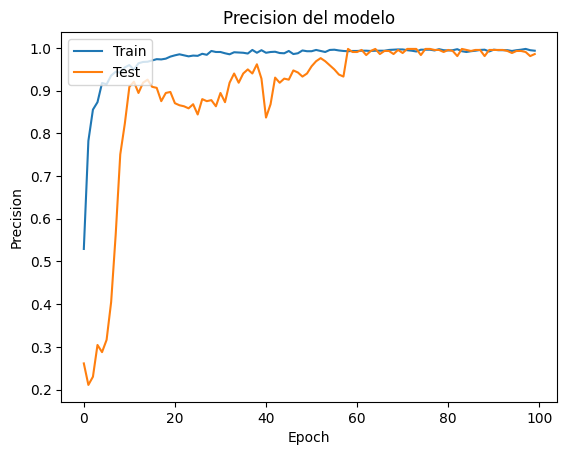

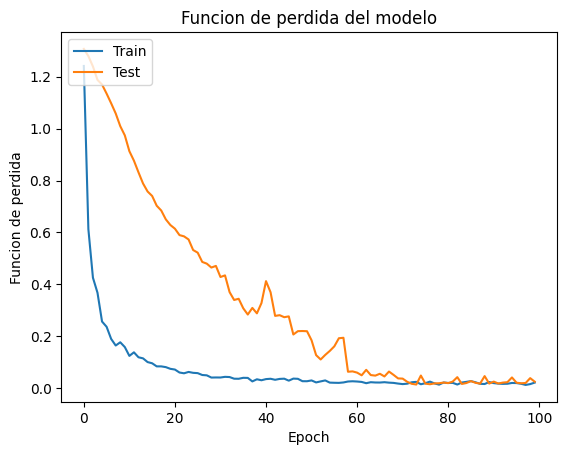

In [7]:
#Evaluar resultados
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precision del modelo')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#Funcion de perdida
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Funcion de perdida del modelo')
plt.ylabel('Funcion de perdida')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Uso del modelo para predicción

In [8]:
from ExtraeFrame import IMAGEN

imagen=IMAGEN("Fotos/foto1.png")
x_new=imagen.extrae(muestra=True)
x_new=np.array([x_new])

prediccion  = best_model.predict(x_new)
print (prediccion)
label  = poses_lb.inverse_transform(prediccion)
print(label)

I0000 00:00:1753309830.204409  324962 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1753309830.226668  341898 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.163.01), renderer: NVIDIA GeForce RTX 4060 Laptop GPU/PCIe/SSE2
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1753309830.267514  341867 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1753309830.330841  341892 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1753309830.370512  341866 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


Analizando Imagen
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
[[9.3269703e-10 9.5857865e-01 4.1418198e-02 3.2549160e-06]]
['FIRMES']


In [19]:
from ExtraeFrame import VideoPrediccion
best_model=load_model("/home/misa/GitHub/Timeless-Turing/models/best_model_7.keras")
prueba1 = VideoPrediccion("/home/misa/GitHub/Timeless-Turing/data/processed_videos/Gaby_2.mp4")
prueba1.AnalizaVideo(best_model,poses_lb, csv_path="Gaby_2.csv", step=3,reproduce=True)

Iniciando analisis de Video:
Analizando Imagen


I0000 00:00:1753318886.343200  324962 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1753318886.375633  531929 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.163.01), renderer: NVIDIA GeForce RTX 4060 Laptop GPU/PCIe/SSE2
W0000 00:00:1753318886.413024  531897 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1753318886.490049  531922 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
FIRMES
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
FIRMES
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
FIRMES
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
FIRMES
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
FIRMES
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
FIRMES
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
FIRMES
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
FIRMES
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
OTRO
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
OTRO
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
BRAZOS_CRUZADOS
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
BRAZOS_CRUZADOS
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
BRAZOS_CRUZADOS
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
BRAZOS_CRUZADOS
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
BRAZOS_CRUZADOS
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
BRAZOS_CRUZADOS
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
BRAZOS_CRUZADOS
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
OTRO
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
OTRO
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
FIRMES
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
FIRMES